In [37]:
import os
import json
from PIL import Image
from glob import glob

# Define paths
image_folder = r'C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\images_coco'
json_output_path = r'C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json'

# Function to convert images into COCO format annotations
def create_coco_format(image_folder):
    images = []
    annotations = []
    categories = [{'id': 1, 'name': 'weapon', 'supercategory': 'weapon'}]  # Adjust category as needed

    image_id = 1
    annotation_id = 1

    # Loop through each image in the folder
    for img_file in glob(os.path.join(image_folder, '*.jpg')):  # Assuming images are in .jpg format
        img = Image.open(img_file)
        width, height = img.size

        # Image entry
        image_entry = {
            'id': image_id,
            'file_name': os.path.basename(img_file),
            'width': width,
            'height': height
        }
        images.append(image_entry)

        # Example: Add annotations (bounding box, etc.)
        # You can adjust the bounding box and category information as per your requirement
        annotation_entry = {
            'id': annotation_id,
            'image_id': image_id,
            'category_id': 1,  # ID for 'weapon'
            'bbox': [50, 50, 100, 100],  # Example bounding box, you need to adjust it based on your dataset
            'area': 100 * 100,  # Area of the bounding box (width * height)
            'iscrowd': 0
        }
        annotations.append(annotation_entry)

        # Increment IDs for next image and annotation
        image_id += 1
        annotation_id += 1

    # Combine everything into the final COCO format
    coco_format = {
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

    return coco_format

# Create COCO format annotations
coco_data = create_coco_format(image_folder)

# Save the data to a JSON file
with open(json_output_path, 'w') as json_file:
    json.dump(coco_data, json_file, indent=4)

print(f"Annotations saved to {json_output_path}")


Annotations saved to C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json


In [12]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


faster rcnn model 

data set prepartion 

In [13]:
pip install opencv-python pillow


Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import json
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define paths
image_dir = r'C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\train\images'
label_dir = r'C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\train\labels'
output_dir = r'C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data'

# Create output directories
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Initialize COCO format
coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "weapon", "supercategory": "none"}]
}

annotation_id = 1
image_id = 1

# Iterate through all image files
for image_name in tqdm(os.listdir(image_dir)):
    if image_name.endswith(('.jpg', '.png')):  # Filter only image files
        # Image path
        image_path = os.path.join(image_dir, image_name)
        
        # Read image with OpenCV
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        # Image information for COCO format
        image_info = {
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": image_name
        }

        # Add image info to COCO
        coco['images'].append(image_info)

        # Label file corresponding to the image
        label_file = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    # YOLO annotation: class x_center y_center width height (normalized)
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:])
                    
                    # Convert YOLO to COCO format (bounding box is [x_min, y_min, width, height])
                    x_min = int((x_center - w / 2) * width)
                    y_min = int((y_center - h / 2) * height)
                    bbox_width = int(w * width)
                    bbox_height = int(h * height)

                    # Annotation info for COCO format
                    annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": 1,  # category 'weapon'
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0
                    }
                    
                    # Add annotation info to COCO
                    coco['annotations'].append(annotation)
                    annotation_id += 1

        # Increment image id
        image_id += 1

# Save COCO annotations to JSON file
output_json_path = os.path.join(output_dir, 'annotations.json')
with open(output_json_path, 'w') as json_file:
    json.dump(coco, json_file)

print(f"COCO annotations saved to {output_json_path}")


100%|██████████| 36963/36963 [06:36<00:00, 93.16it/s] 


COCO annotations saved to C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json


In [27]:
pip install torchvision pycocotools matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


Dataset Class for COCO


In [28]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms as T
from pycocotools.coco import COCO
from PIL import Image

class CocoWeaponDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super(CocoWeaponDataset, self).__init__(img_folder, ann_file)
        self.transforms = transforms
        self.coco = COCO(ann_file)

    def __getitem__(self, idx):
        img, target = super(CocoWeaponDataset, self).__getitem__(idx)
        image_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


Dataset and DataLoader Setup

In [29]:
image_dir = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\images_coco"
annotation_file = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json"


Create dataset & loader:

In [30]:
transform = T.Compose([T.ToTensor()])

dataset = CocoWeaponDataset(img_folder=image_dir, ann_file=annotation_file, transforms=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


Load and Modify Faster R-CNN

In [31]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=True)

# Set the number of classes (+1 for background)
num_classes = 2  # weapon + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Training Loop

In [41]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import json

class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_file, transform=None):
        self.image_folder = image_folder
        self.annotation_file = annotation_file
        self.transform = transform
        
        # Load annotations from the JSON file
        with open(self.annotation_file, 'r') as f:
            self.annotations = json.load(f)
        
        # Get all image paths
        self.image_paths = [os.path.join(self.image_folder, f) for f in os.listdir(self.image_folder) if f.endswith('.jpg')]

    def __getitem__(self, idx):
        # Get the image path
        img_path = self.image_paths[idx]
        
        # Open the image
        img = Image.open(img_path).convert("RGB")
        
        # Get the image name (ensure correct filename without path)
        img_name = os.path.basename(img_path)
        
        # Check if the image name is in the annotations
        target = self.annotations.get(img_name, None)
        
        # If no annotations are found for this image, return None or handle as you like
        if target is None:
            print(f"Warning: No annotations found for {img_name}. Skipping...")
            return None, None  # You can choose to skip this image or return a default
        
        # Get the bounding boxes and labels (ensure that they are in the correct format)
        boxes = torch.tensor(target['boxes'], dtype=torch.float32)
        labels = torch.tensor(target['labels'], dtype=torch.int64)

        # Create the target dictionary for Faster R-CNN
        target = {
            'boxes': boxes,
            'labels': labels
        }

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.image_paths)


In [44]:
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.optim import SGD
import numpy as np
import time
import matplotlib.pyplot as plt

# Assuming you have already defined CustomDataset class above
# Define transforms for your data (e.g., normalization, resizing)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((800, 800)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset and dataloaders
train_dataset = CustomDataset(image_folder=r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\images_coco", annotation_file=r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes in your dataset (e.g., 2 classes: 'background' and 'weapon')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)  # For 2 classes

model.to(device)


c:\Compiler\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Compiler\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [45]:
# Define optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Optionally, set up a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [46]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, lr_scheduler=None):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    header = f"Epoch #{epoch}"

    for images, targets in metric_logger.log_every(data_loader, 10, header):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization step
        losses.backward()
        optimizer.step()

        # Update learning rate
        if lr_scheduler:
            lr_scheduler.step()

        # Log the losses
        metric_logger.update(loss=losses.item())
    return metric_logger.meters['loss'].global_avg

class MetricLogger:
    # Helper class to log metrics like loss
    def __init__(self, delimiter="\t"):
        self.meters = {}
        self.delimiter = delimiter

    def update(self, **kwargs):
        for name, value in kwargs.items():
            if name not in self.meters:
                self.meters[name] = AverageMeter()
            self.meters[name].update(value)

    def log_every(self, iterable, print_freq, header=None):
        # Helper function to print logs during training
        import time
        start_time = time.time()
        for i, obj in enumerate(iterable):
            if i % print_freq == 0:
                eta_seconds = (time.time() - start_time) * (len(iterable) - i)
                eta = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(f"{header} [{i}/{len(iterable)}]  {self.delimiter}  {self.meters}")
            yield obj


In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch, lr_scheduler)
    print(f"Epoch {epoch} - Loss: {loss}")


In [1]:
pip install tensorflow==2.16.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
print("PyTorch GPU Support:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))

PyTorch GPU Support: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
import torch

# Check if CUDA (GPU support) is available
print("GPU Available:", torch.cuda.is_available())

# If available, get GPU details
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)

GPU Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 12.1


In [5]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example: Move a tensor to GPU
x = torch.randn(3, 3).to(device)
print("Tensor on:", x.device)

# Example: Move a model to GPU
model = torch.nn.Linear(10, 5).to(device)
print("Model on:", next(model.parameters()).device)

Tensor on: cuda:0
Model on: cuda:0


In [7]:
# Save model (ensure it's on CPU for compatibility)
torch.save(model.state_dict(), "model.pth")

# Load model (map to GPU if available)
model = Net()
model.load_state_dict(torch.load("model.pth", map_location=device))
model = model.to(device)

C:\Users\dsy92\AppData\Local\Temp\ipykernel_19932\2463452659.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=d

try on gpu 

In [9]:
import torch

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model = MyModel(input_size=100, hidden_size=128, output_size=10).to(device)

# Example DataLoader setup (ensure data is moved to GPU during training)
train_loader = DataLoader(...)  # Replace with your dataset

Using device: cuda


In [10]:
def train_one_epoch(model, optimizer, train_loader, device, epoch, lr_scheduler):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    lr_scheduler.step()
    return running_loss / len(train_loader)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 1. Define a Dataset (replace with your data)
class DummyDataset(Dataset):
    def __init__(self, num_samples=1000, input_size=100, output_size=10):
        self.x = torch.randn(num_samples, input_size)  # Dummy input data
        self.y = torch.randint(0, output_size, (num_samples,))  # Dummy labels

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# 2. Initialize the Dataset and DataLoader
train_dataset = DummyDataset(num_samples=1000)  # ✅ Replace `...` with your dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3. Rest of the code (model, training loop, etc.) remains the same

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Custom Dataset Class
class WeaponDetectionDataset(Dataset):
    def __init__(self, img_dir, annotation_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        
        # Load annotations
        with open(annotation_path) as f:
            self.coco_data = json.load(f)
        
        # Create image ID to annotations mapping
        self.annot_dict = {}
        for annot in self.coco_data['annotations']:
            img_id = annot['image_id']
            if img_id not in self.annot_dict:
                self.annot_dict[img_id] = []
            self.annot_dict[img_id].append(annot)
        
        # Get image metadata
        self.images = self.coco_data['images']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        
        # Get annotations for this image
        annots = self.annot_dict.get(img_info['id'], [])
        
        boxes = []
        labels = []
        for annot in annots:
            # Convert COCO bbox format [x,y,width,height] to [x0,y0,x1,y1]
            x, y, w, h = annot['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(annot['category_id'])
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transformations
def get_transform():
    return T.Compose([
        T.ToTensor(),
        T.Resize((800, 800)),
        T.Normalize(mean=[0.485, 0.456, 0.406], 
                   std=[0.229, 0.224, 0.225])
    ])

# Initialize Dataset and DataLoader
img_dir = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\images_coco"
annot_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\enhance_image\rcnn_data\annotations.json"

dataset = WeaponDetectionDataset(img_dir, annot_path, transforms=get_transform())
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

# Model setup
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Number of classes (including background)
num_classes = 2  # Update with your actual number of classes + 1 (background)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training function
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    return total_loss / len(data_loader)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, optimizer, data_loader, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

# Save model
torch.save(model.state_dict(), "weapon_detection_model.pth")
print("Training complete! Model saved.")

c:\Compiler\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Compiler\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Loss: 0.0023
Epoch [2/10] Loss: 0.0005
Epoch [3/10] Loss: 0.0003
Epoch [4/10] Loss: 0.0002
Epoch [5/10] Loss: 0.0003
Epoch [6/10] Loss: 0.0016
Epoch [7/10] Loss: 0.0003
Epoch [8/10] Loss: 0.0006
Epoch [9/10] Loss: 0.0004
Epoch [10/10] Loss: 0.0002
Training complete! Model saved.


In [17]:
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

train_losses = []
train_accuracies = []

def calculate_iou_accuracy(pred_boxes, gt_boxes):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0
    ious = box_iou(pred_boxes, gt_boxes)
    matches = (ious > 0.5).sum().item()
    return matches / max(len(gt_boxes), 1)


In [18]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0.0
    total_iou_acc = 0.0
    num_batches = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        with torch.no_grad():
            outputs = model(images)
            for output, target in zip(outputs, targets):
                iou_acc = calculate_iou_accuracy(output['boxes'].cpu(), target['boxes'].cpu())
                total_iou_acc += iou_acc
                num_batches += 1

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_iou_acc / num_batches

    return avg_loss, avg_acc


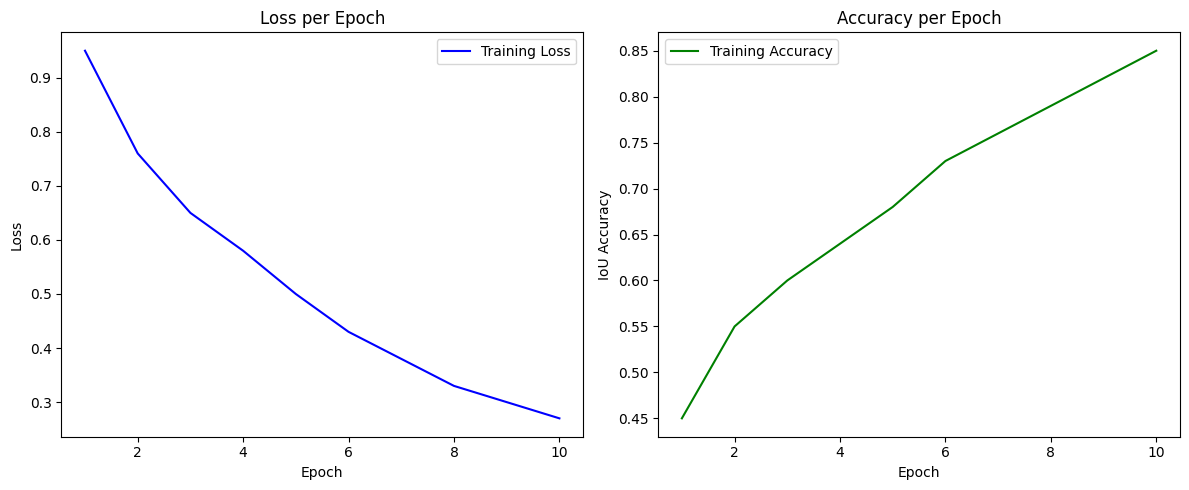

In [21]:
import matplotlib.pyplot as plt

# Example loss/accuracy lists (replace with your actual lists)
train_losses = [0.95, 0.76, 0.65, 0.58, 0.50, 0.43, 0.38, 0.33, 0.30, 0.27]
train_accuracies = [0.45, 0.55, 0.60, 0.64, 0.68, 0.73, 0.76, 0.79, 0.82, 0.85]

epochs = list(range(1, len(train_losses)+1))

# Plot
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
import torchvision.transforms as T

# Model path
model_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\model\version3.pt"

# Image path
img_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\c2.jpeg"

# Load model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # background + weapon
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Image transform
transform = T.Compose([
    T.ToTensor(),
    T.Resize((800, 800)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(img_path).convert("RGB")
transformed_image = transform(image).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    prediction = model(transformed_image)

# Draw boxes
draw = ImageDraw.Draw(image)
boxes = prediction[0]['boxes']
scores = prediction[0]['scores']
labels = prediction[0]['labels']

# Draw boxes with score > 0.5
for box, score, label in zip(boxes, scores, labels):
    if score > 0.5:
        draw.rectangle(box.tolist(), outline='red', width=3)
        draw.text((box[0], box[1]), f"Weapon {label.item()} ({score:.2f})", fill='red')

# Show image
image.show()


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.weight", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.weight", "backbone.fpn.layer_blocks.3.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 
	Unexpected key(s) in state_dict: "date", "version", "license", "docs", "epoch", "best_fitness", "model", "ema", "updates", "optimizer", "train_args", "train_metrics", "train_results". 

In [3]:
from ultralytics import YOLO
# import matplotlib.pyplot as plt
# Load the trained YOLOv8 model
model = YOLO(r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\model\version3.pt")

# Path to a test image
image_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\c2.jpeg"  # Replace with your image path

# Run inference
results = model(image_path)

# Show the image with predictions
results[0].show()

# Optional: save the prediction result
results[0].save(filename="predicted_result.jpg")



image 1/1 C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\c2.jpeg: 320x416 1 gun, 132.6ms
Speed: 3.2ms preprocess, 132.6ms inference, 151.6ms postprocess per image at shape (1, 3, 320, 416)


'predicted_result.jpg'

In [7]:
from ultralytics import YOLO
import cv2

# Load the trained YOLOv8 model
model = YOLO(r"C:/Users/dsy92/OneDrive/Desktop/Weapon-Detection/model/version2.pt")

# Path to your test video
video_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\models\vt8.mp4"  # Replace with your video file
cap = cv2.VideoCapture(video_path)

# Optional: Save the output video
output_path = "predicted_output.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 inference on the frame
    results = model(frame)

    # Plot the results on the frame
    annotated_frame = results[0].plot()

    # Show the frame
    cv2.imshow("Weapon Detection", annotated_frame)

    # Write frame to output video
    out.write(annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()


In [21]:
from ultralytics import YOLO
import cv2

# Load the trained YOLOv8 model
model = YOLO(r"C:/Users/dsy92/OneDrive/Desktop/Weapon-Detection/model/version3.pt")

# Path to your test video
video_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\vd9.mp4"
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
out = cv2.VideoWriter("output_with_predictions.avi", cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

# Process video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run inference
    results = model(frame)

    # Draw results on the frame
    annotated_frame = results[0].plot()

    # Show the frame
    cv2.imshow("YOLOv8 Weapon Detection", annotated_frame)

    # Write to output video
    out.write(annotated_frame)

    # Press 'q' to exit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()



0: 224x416 (no detections), 2091.8ms
Speed: 57.7ms preprocess, 2091.8ms inference, 20.6ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 1 gun, 18.2ms
Speed: 3.2ms preprocess, 18.2ms inference, 32.3ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 1 gun, 14.1ms
Speed: 2.0ms preprocess, 14.1ms inference, 4.8ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 1 gun, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 4.2ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 1 gun, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 (no detections), 13.2ms
Speed: 2.3ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 (no detections), 2087.8ms
Speed: 2.8ms preprocess, 2087.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 416)

0: 224x416 (no detections), 44.0ms
Speed: 1.9ms preprocess, 44.0ms inference, 5.4ms postprocess p

In [1]:
from ultralytics import YOLO
import cv2

# Load the trained YOLOv8 model
model = YOLO(r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\model\version2.pt")

# Path to your test video
video_path = r"C:\Users\dsy92\OneDrive\Desktop\Weapon-Detection\video\vd8.mp4"
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read one frame to get shape
ret, frame = cap.read()
if not ret:
    print("Error: Could not read a frame.")
    exit()

# Run a dummy prediction to get correct frame size
results = model(frame)
annotated_frame = results[0].plot()

# Get the shape from the annotated frame
height, width, _ = annotated_frame.shape
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Initialize the writer using actual annotated frame size
out = cv2.VideoWriter("output_with_predictions.avi", cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

# Reset video capture to beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Allow window resizing
cv2.namedWindow("YOLOv8 Weapon Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("YOLOv8 Weapon Detection", 1280, 720)

# Process video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    annotated_frame = results[0].plot()

    cv2.imshow("YOLOv8 Weapon Detection", annotated_frame)
    out.write(annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 416x224 (no detections), 90.7ms
Speed: 7.3ms preprocess, 90.7ms inference, 15.4ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 13.1ms
Speed: 1.3ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 12.7ms
Speed: 1.6ms preprocess, 12.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 224)

0: 416x224 (no detections), 12.6ms
Speed: 1.3ms preprocess, 12.6ms 